In [61]:
# Import modules
import numpy as np

# Import functions
from local_global_matrices import *
from assembly_K_matrices import *
from assembly_B_matrices import *
from RegularSudomainsMesh import RegularSubdomainsMesh
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Import data
d_dat = np.genfromtxt('data/d.dat')
fP_dat = np.genfromtxt('data/fP.dat')
fr_dat = np.genfromtxt('data/fr.dat')
Ks = np.genfromtxt('data/localK.dat')
solution = np.genfromtxt('data/solution.dat')

In [3]:
# Initial data
# Number of subdomains
Nsub_x = 4
Nsub_y = 3

# Number of remaining nodes in each subdomain
Nr_x = 4
Nr_y = 3

# Local remaining and primal indices
rs = np.array([1, 2, 4, 5, 6, 7, 9, 10])
qs = np.array([0, 3, 8, 11])

In [4]:
# Transformation matrices A
# Primal nodes local-global transformation matrices
APq = create_APq_matrices(Nsub_x, Nsub_y)

# Remaining nodes local-global transformation matrices
ARr = create_ARr_matrices(Nsub_x, Nsub_y, Nr_x, Nr_y)

In [5]:
# Stiffness matrices K
KRR = assembly_KRR_matrix(Ks, ARr, rs)
KPP = assembly_KPP_matrix(Ks, APq, qs)
KRP = assembly_KRP_matrix(Ks, APq, ARr, qs, rs)
KPR = KRP.T

In [6]:
Nr = Nr_x*Nr_y - 4  # Number of local remaining nodes r
NR = Nr*(Nsub_x*Nsub_y)  # Number of total remaining nodes R
Nq = 4 # Number of primal nodes in each subdomain 
NP = (Nsub_x + 1)*(Nsub_y + 1) # Total number of primal nodes

In [7]:
NlambdaR = (Nsub_x*(Nr_x - 2)) * (Nsub_y - 1) + (Nsub_y*(Nr_y - 2)) * (Nsub_x - 1)
NlambdaP_Dir = 4 # hardcoded
NlambdaR_Dir = 3 # hardcoded

Nlambda = NlambdaR + NlambdaR_Dir + NlambdaP_Dir

In [65]:
BlambdaR = assembly_BR_matrix(Nr_x, Nr_y, Nsub_x, Nsub_y, Nlambda, ARr)

In [57]:
# Dirichlet boundary conditions
# Left wall remaining
BlambdaR = assembly_Dirichlet_BR_matrix(Nlambda, NR, Nsub_y, Nr, Nr_x, Nr_y, NlambdaR, Nsub_x, ARr, BlambdaR)

#Left wall primal
BlambdaP = assembly_Dirichlet_BP_matrix(Nsub_x, Nsub_y, Nr_y, Nlambda, NP, Nq, NlambdaR, APq)

In [63]:
# Assembly d
d[NlambdaR:]=d_dat

In [64]:
# Assembly f
# fP
fP = fP_dat




In [15]:
def assembly_fR_vector(fR):
    fR = np.zeros(NR)
    for j in range(Nsub_y):
        for i in range(Nsub_x):
            Rs = []
            for sj in range(Nr_y):
                if sj == 0:
                    Rs = np.concatenate([Rs, np.arange(j*(Nsub_x*Nr) + i*(Nr_x - 2), j*(Nsub_x*Nr) + i*(Nr_x - 2) + Nr_x - 2)])
                elif sj == Nr_y - 1:
                    Rs = np.concatenate([Rs, np.arange(j*(Nsub_x*Nr) + i*(Nr_x - 2) + Nsub_x*Nr_x*(Nr_y - 2) + Nsub_x*(Nr_x - 2),
                                                    j*(Nsub_x*Nr) + i*(Nr_x - 2) + Nsub_x*Nr_x*(Nr_y - 2) + Nsub_x*(Nr_x - 2) + Nr_x - 2)])
                else:
                    Rs = np.concatenate([Rs, np.arange(j*(Nsub_x*Nr) + i*(Nr_x) + Nsub_x*Nr_x*(sj - 1) + Nsub_x*(Nr_x - 2), 
                                                    j*(Nsub_x*Nr) + i*(Nr_x) + Nsub_x*Nr_x*(sj - 1) + Nsub_x*(Nr_x - 2) + Nr_x)])
            fR[Rs.astype(int)] = fr_dat
    return fR



In [16]:
print(np.shape(KPP), np.shape(KPR), np.shape(np.linalg.inv(KRR)), np.shape(KRP))

(20, 20) (20, 96) (96, 96) (96, 20)


In [17]:
KRR_inv = np.linalg.inv(KRR)
SPP = KPP - KPR @ KRR_inv @ KRP
SPP_inv = np.linalg.inv(SPP)
np.shape(KRR_inv)

(96, 96)

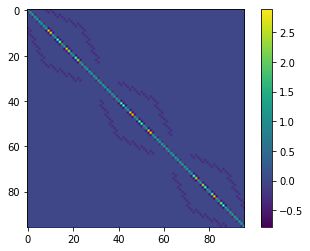

array([[ 1.44444444, -0.38888889,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.38888889,  1.44444444,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.44444444, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.44444444,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.44444444, -0.38888889],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.38888889,  1.44444444]])

In [46]:
plot_sparse_matrix(KRR)
KRR

In [18]:
fPH = fP - KPR @ KRR_inv @ fR

In [19]:
dH = -d \
    + BlambdaP @ SPP_inv @ fPH \
    + BlambdaR @ KRR_inv @ fR \
    - BlambdaR @ KRR_inv @ KRP @ SPP_inv @ fPH

np.shape(dH)

(32,)

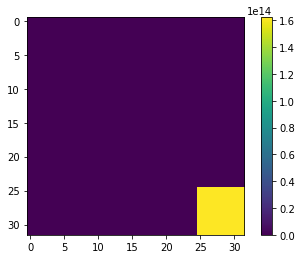

7.337689047883407e+22

In [50]:
F = BlambdaR @ KRR_inv @ BlambdaR.T \
    + BlambdaR @ KRR_inv @ KRP @ SPP_inv @ KPR @ KRR_inv @ BlambdaR.T \
    + BlambdaP @ SPP_inv @ BlambdaP.T \
    - BlambdaP @ SPP_inv @ KPR @ KRR_inv @ BlambdaR.T \
    - BlambdaR @ KRR_inv @ KRP @ SPP_inv @ BlambdaP.T
    
np.shape(F)
plot_sparse_matrix(F)
np.linalg.det(F)

In [21]:
lambda_ = np.linalg.solve(F, dH)

In [22]:
lambda_

array([-0.5728071 , -0.32012243, -0.14662895, -0.38024098, -0.24855982,
       -0.12523919, -0.18251982, -0.18138492, -0.10255132,  0.25687264,
        0.19117563,  0.10022751,  0.06134957,  0.03664798,  0.02276031,
        0.01155264,  0.00904929,  0.28190161,  0.20441327,  0.09354643,
        0.07151719,  0.03394658,  0.02662063,  0.01191943,  0.01102942,
        0.72125411,  0.96613501,  0.6906067 ,  0.56012483,  0.2842102 ,
       -0.03435292, -0.18797794])

In [23]:
uP = SPP_inv @ fPH + SPP_inv @ KPR @ KRR_inv @ BlambdaR.T @ lambda_ - SPP_inv @ BlambdaP.T @ lambda_
uP

array([0.875  , 2.75   , 3.6875 , 4.375  , 4.34375, 1.9375 , 3.     ,
       3.8125 , 4.21875, 4.46875, 2.90625, 3.4375 , 3.9375 , 4.3125 ,
       4.4375 , 3.875  , 3.6875 , 4.0625 , 4.34375, 4.375  ])

In [24]:
uR = KRR_inv @ (fR - KRP @ uP - BlambdaR.T @ lambda_)
uR = KRR_inv @ fR \
    + KRR_inv @ KRP @ SPP_inv @ KPR @ KRR_inv @ fR \
    - KRR_inv @ KRP @ SPP_inv @ fP \
    - KRR_inv @ KRP @ SPP_inv @ KPR @ KRR_inv @ BlambdaR.T @ lambda_ \
    + KRR_inv @ KRP @ SPP_inv @ BlambdaP.T @ lambda_ \
    - KRR_inv @ BlambdaR.T @ lambda_
uR

array([1.78590397, 2.39202086, 3.22802862, 3.34396906, 4.16990749,
       4.29323997, 4.31766814, 4.39934448, 1.39077087, 1.97948151,
       2.64722356, 3.04614357, 2.84729466, 3.22522568, 3.48384941,
       3.62134656, 4.04513916, 4.22907076, 4.11114708, 4.30926138,
       4.24661906, 4.37795435, 4.46223319, 4.49410528, 2.29730473,
       2.71133688, 3.19016821, 3.56615249, 4.3268358 , 4.34884319,
       4.35935968, 4.37717056, 2.33973807, 2.74870635, 3.5442061 ,
       3.80487595, 3.99384971, 4.17576979, 4.21880694, 4.3616844 ,
       2.3970872 , 2.93637399, 2.98211694, 3.30818014, 3.32939678,
       3.56261023, 3.93609284, 4.10828852, 3.97331918, 4.11496965,
       4.23244423, 4.28727208, 4.26427683, 4.28908262, 4.33877621,
       4.30688805, 3.1963817 , 3.24599887, 3.7467917 , 4.09923943,
       4.15021574, 4.22681475, 4.33411172, 4.31888826, 3.25058978,
       3.44007139, 3.64024677, 3.76335627, 4.06717384, 4.13998512,
       4.3789752 , 4.45546612, 3.47999327, 3.50895369, 3.43383

In [27]:
     
    
   

mesh = RegularSubdomainsMesh(4, 3, 4, 3)
mesh.NP



20

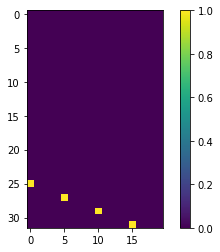

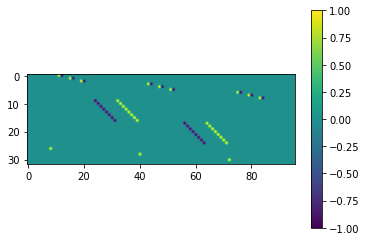

In [28]:
plot_sparse_matrix(BlambdaP)
plot_sparse_matrix(BlambdaR)

In [267]:
d

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ,
       1.5, 2. , 2.5, 3. , 3.5, 4. ])

In [268]:
fR

array([0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.04166667,
       0.04166667, 0.02083333, 0.02083333, 0.04166667, 0.04166667,
       0.02083333, 0.02083333, 0.04166667, 0.04166667, 0.02083333,
       0.02083333, 0.04166667, 0.04166667, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.04166667, 0.04166667, 0.02083333, 0.02083333,
       0.04166667, 0.04166667, 0.02083333, 0.02083333, 0.04166667,
       0.04166667, 0.02083333, 0.02083333, 0.04166667, 0.04166667,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.04166667, 0.04166

In [269]:
fP

array([0.01041667, 0.02083333, 0.02083333, 0.02083333, 0.01041667,
       0.02083333, 0.04166667, 0.04166667, 0.04166667, 0.02083333,
       0.02083333, 0.04166667, 0.04166667, 0.04166667, 0.02083333,
       0.01041667, 0.02083333, 0.02083333, 0.02083333, 0.01041667])

In [270]:
BlambdaR.T @ lambda_ + KRP @ uP + KRR @ uR

array([-0.0390625 ,  0.0234375 ,  0.18576389, -0.13802083,  0.20920139,
        0.0234375 , -0.07725694,  0.03038194,  0.0390625 , -0.05381944,
        0.47135417,  0.08506944,  0.01909722,  0.17795139,  0.09722222,
       -0.0859375 ,  0.01388889,  0.51649306, -0.45572917, -0.00173611,
       -0.01909722,  0.08333333,  0.16232639,  0.09635417, -0.09461806,
       -0.00260417, -0.15277778,  0.08767361,  0.32899306,  0.08072917,
        0.04079861, -0.07552083,  0.03472222, -0.00434028,  0.14756944,
        0.14496528, -0.03559028,  0.06163194, -0.09982639,  0.06770833,
       -0.12586806,  0.69270833, -0.23263889,  0.09288194, -0.03559028,
       -0.1328125 ,  0.41232639, -0.01475694,  0.06163194,  0.125     ,
        0.13715278, -0.02170139,  0.09722222, -0.04079861,  0.02604167,
       -0.04079861,  0.16319444, -0.18489583, -0.03819444,  0.30989583,
        0.05121528, -0.01128472,  0.0234375 , -0.046875  ,  0.20746528,
        0.19097222,  0.08940972, -0.11892361,  0.00868056, -0.08

In [271]:
fR

array([0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.04166667,
       0.04166667, 0.02083333, 0.02083333, 0.04166667, 0.04166667,
       0.02083333, 0.02083333, 0.04166667, 0.04166667, 0.02083333,
       0.02083333, 0.04166667, 0.04166667, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.04166667, 0.04166667, 0.02083333, 0.02083333,
       0.04166667, 0.04166667, 0.02083333, 0.02083333, 0.04166667,
       0.04166667, 0.02083333, 0.02083333, 0.04166667, 0.04166667,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.02083333, 0.02083333,
       0.02083333, 0.02083333, 0.02083333, 0.04166667, 0.04166

In [272]:
BlambdaP.T @ lambda_ + KPP @ uP + KPR @ uR 

array([-0.0174999 , -0.17025262, -0.16793745,  0.14291245, -0.06022913,
        0.01597163, -0.21150344, -0.34354657, -0.13110147,  0.12274727,
       -0.18925591, -0.1891647 , -0.18483252,  0.10703192,  0.05963869,
       -0.04327133, -0.08194167,  0.07410994,  0.06507361, -0.05562938])

In [273]:
fP

array([0.01041667, 0.02083333, 0.02083333, 0.02083333, 0.01041667,
       0.02083333, 0.04166667, 0.04166667, 0.04166667, 0.02083333,
       0.02083333, 0.04166667, 0.04166667, 0.04166667, 0.02083333,
       0.01041667, 0.02083333, 0.02083333, 0.02083333, 0.01041667])

In [276]:
BlambdaP @ uP + BlambdaR @ uR

array([ 0.19884891, -0.42379261,  0.06264231, -0.02121664,  0.13496934,
        0.02299525, -0.07904804, -0.02015091,  0.04121267,  0.04243335,
        0.03736947,  0.3540379 ,  0.23872345, -0.33298609, -0.1730734 ,
       -0.14055274, -0.01548615,  0.05420808,  0.19407252, -0.10654493,
       -0.33588317, -0.0830419 , -0.08682964,  0.04486348,  0.13657785,
        0.875     ,  1.39077087,  1.9375    ,  2.3970872 ,  2.90625   ,
        3.47999327,  3.875     ])

In [275]:
d

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ,
       1.5, 2. , 2.5, 3. , 3.5, 4. ])